# Clasificador de Audio para la detección de Pájaro Capuchino

El objetivo de este proyecto es simple: usar redes neuronales convolucionales para crear un clasificador que sea capaz de detectar si un audio que se reproduce pertenece o no a un pájaro capuchino.


## 1.1 Instalar dependencias

In [1]:
import tensorflow as tf

print("TensorFlow version:", tf.__version__)
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))

/Users/erickavendanogarcia/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:61: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


TensorFlow version: 2.16.2
Num GPUs Available: 1


## 1.2 Cargar las dependencias

In [2]:
import os
from matplotlib import pyplot as plt
import tensorflow as tf
import tensorflow_io as tfio

## 1.3 Definir las rutas de los archivos

In [3]:
from dotenv import load_dotenv
import os

load_dotenv()
BASE_DIR = os.getenv('BASE_DIR')

CAPUCHIN_FILE = os.path.join(BASE_DIR, "Parsed_Capuchinbird_Clips", "XC3776-3.wav")
NOT_CAPUCHIN_FILE = os.path.join(BASE_DIR, "Parsed_Not_Capuchinbird_Clips", "afternoon-birds-song-in-forest-0.wav")

## 1.4 Construir una función que cargue los datos

In [4]:
import tensorflow as tf
import numpy as np
from scipy.signal import resample

def load_wav_16k_mono(filename):
    # Lee el archivo wav
    file_contents = tf.io.read_file(filename)
    wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
    wav = tf.squeeze(wav, axis=-1).numpy()  # convertimos a numpy para SciPy

    sample_rate = sample_rate.numpy()  # tensor -> int

    # Re-muestreo si no está en 16kHz
    if sample_rate != 16000:
        num_samples = int(len(wav) * 16000 / sample_rate)
        wav = resample(wav, num_samples)

    return wav


## 1.5 Graficamos la onda

2025-09-16 23:34:46.441409: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2025-09-16 23:34:46.441530: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2025-09-16 23:34:46.441543: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2025-09-16 23:34:46.441754: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-09-16 23:34:46.441770: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


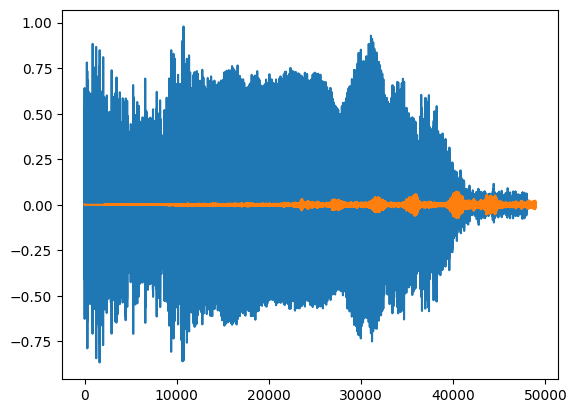

In [5]:
wave = load_wav_16k_mono(CAPUCHIN_FILE)
nwave = load_wav_16k_mono(NOT_CAPUCHIN_FILE)
plt.plot(wave)
plt.plot(nwave)
plt.show()

## 2. Crear un DataSet con Tensorflow

In [6]:
POS=os.path.join(BASE_DIR, "Parsed_Capuchinbird_Clips")
NEG= os.path.join(BASE_DIR, "Parsed_Not_Capuchinbird_Clips")

In [7]:
# esto nos darpa un conjunto de archivos como cadena dentro de un dataset de Tensorflow
pos=tf.data.Dataset.list_files(POS+'/*wav')
neg=tf.data.Dataset.list_files(NEG+'/*wav')

En la siguiente sección es prudente usar la transformada corta de fourier para obtener una representación visual (una imagen) con el espectro del sonido emitido por el pajáro capuccino.

## 2.1 Añadir etiquetas y combinar los samples positivos y negativos

In [8]:
positives = tf.data.Dataset.zip((pos, tf.data.Dataset.from_tensor_slices(tf.ones(len(pos)))))
negatives = tf.data.Dataset.zip((neg, tf.data.Dataset.from_tensor_slices(tf.zeros(len(neg)))))
data = positives.concatenate(negatives)

## 2.2 Determinar la duración promedio del canto de un capuchino

In [9]:
lengths = []
#Esto obtiene los archivos dentro de la carpeta
for file in os.listdir(os.path.join(BASE_DIR, 'Parsed_Capuchinbird_Clips')):
    #ahora cada uno lo pasamos por su forma de onda
    tensor_wave = load_wav_16k_mono(os.path.join(BASE_DIR, 'Parsed_Capuchinbird_Clips', file))
    #Appendeamos lengths con la longitud del tensor de la onda
    lengths.append(len(tensor_wave))

## 2.3 Calcular el promedio, el mínimo y el máximo

In [10]:
tf.math.reduce_mean(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=54156>

In [11]:
tf.math.reduce_min(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=32000>

In [12]:
tf.math.reduce_max(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=80000>

## 3. Construir una función de preprocesamiento para convertir en un espectrograma

In [13]:
def preprocess(file_path, label):
    wav = tf.numpy_function(load_wav_16k_mono, [file_path], tf.float32)
    wav.set_shape([None])  # Necesario porque numpy_function pierde el shape

    # Cortamos o rellenamos a 48000
    wav = wav[:48000]
    zero_padding = tf.zeros([48000] - tf.shape(wav), dtype=tf.float32)
    wav = tf.concat([zero_padding, wav], 0)

    spectrogram = tf.signal.stft(wav, frame_length=256, frame_step=128)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=-1)
    spectrogram = tf.math.log(spectrogram + 1e-9)
    spectrogram = (spectrogram - tf.reduce_min(spectrogram)) / (tf.reduce_max(spectrogram) - tf.reduce_min(spectrogram))
    return spectrogram, label


## 3.1 Probar la función y visualizar el espectrograma

In [14]:
filepath, label = negatives.shuffle(buffer_size=10000).as_numpy_iterator().next()

In [15]:
spectrogram, label = preprocess(filepath, label)

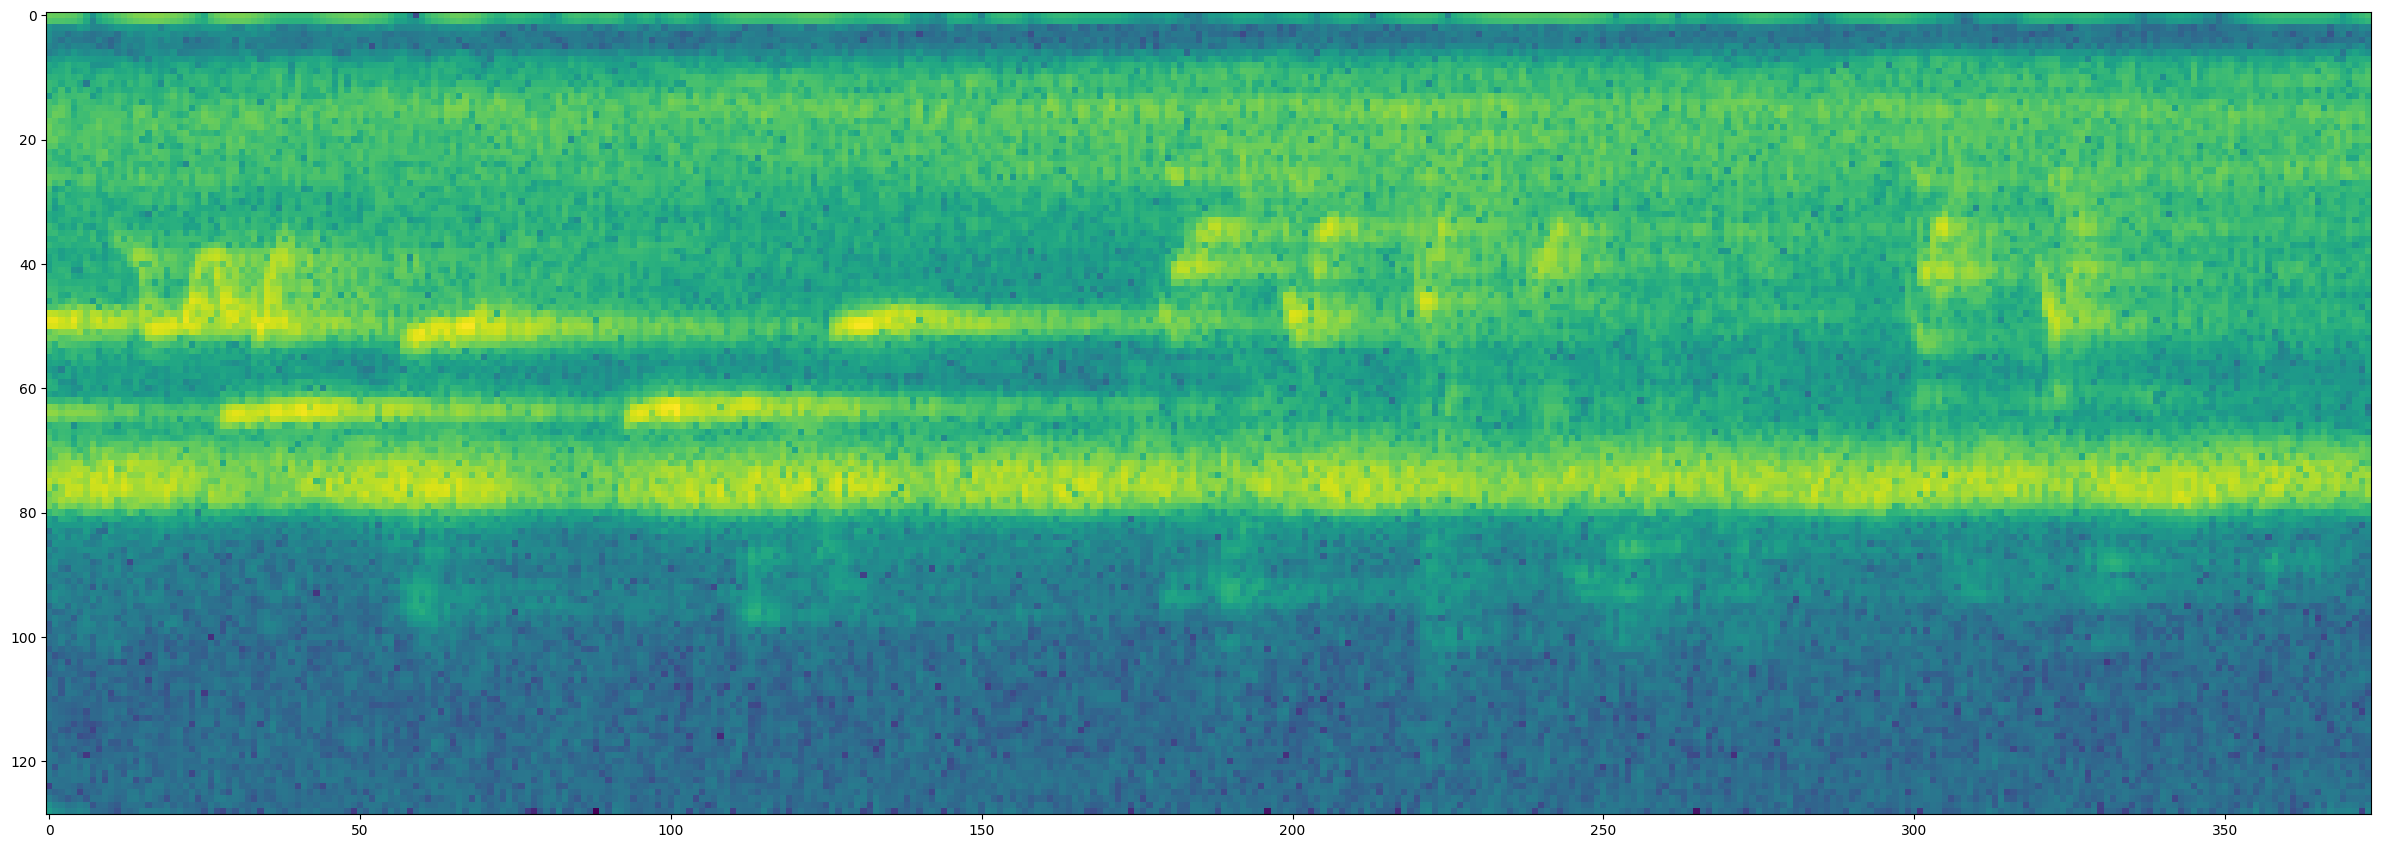

In [16]:
plt.figure(figsize=(30,20))
plt.imshow(tf.transpose(spectrogram)[0])
plt.show()

## 4. Crear un conjunto de entrenamiento y de prueba

In [17]:
data = data.map(preprocess)
data = data.cache()
data = data.shuffle(buffer_size=1000)
data = data.batch(16)
data = data.prefetch(8)

## 4.1 Dividir en conjunto de prueba y de entrenamiento

In [18]:
train = data.take(36)
test = data.skip(36).take(15)

## 4.2 Test one batch

In [19]:
samples, labels = train.as_numpy_iterator().next()
samples.shape

(16, 374, 129, 1)

In [20]:
labels

array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0.],
      dtype=float32)

## 5. Construyamos el modelo

## 5.1 Cargar las dependencias de TensorFlow

In [21]:
from tensorflow.keras.models import Sequential

## 5.2 Construcción del modelo

In [22]:
from tensorflow.keras.layers import Input, Conv2D, Flatten, Dense

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential([
    Input(shape=(374, 129, 1)),  # reemplaza ? con las nuevas dimensiones
    Conv2D(16, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    Conv2D(32, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

In [23]:
model.compile('Adam', loss='BinaryCrossentropy', metrics=[tf.keras.metrics.Recall(),tf.keras.metrics.Precision()])

In [24]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 372, 127, 16)   │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 186, 63, 16)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 184, 61, 32)    │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 92, 30, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 88320)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     5,652,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,657,409 (21.58 MB)

 Trainable params: 5,657,409 (21.58 MB)

 Non-trainable params: 0 (0.00 B)

## 5.3 Entrenar el modelo

In [25]:
hist = model.fit(train, epochs=10, validation_data=test)

Epoch 1/10


2025-09-16 23:34:56.942781: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step - loss: 2.1244 - precision: 0.2967 - recall: 0.3600 - val_loss: 1.3443 - val_precision: 1.0000 - val_recall: 0.0339
Epoch 2/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - loss: 2.1444 - precision: 0.3281 - recall: 0.4065 - val_loss: 1.1106 - val_precision: 1.0000 - val_recall: 0.0612
Epoch 3/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - loss: 2.1859 - precision: 0.3430 - recall: 0.3907 - val_loss: 0.2718 - val_precision: 0.8947 - val_recall: 0.5484
Epoch 4/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - loss: 1.8734 - precision: 0.3962 - recall: 0.4437 - val_loss: 0.3344 - val_precision: 0.6863 - val_recall: 0.9859
Epoch 5/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - loss: 1.8719 - precision: 0.4268 - recall: 0.4698 - val_loss: 0.1462 - val_precision: 0.8814 - val_recall: 0.8525
Epoch 6/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - loss: 1.5002 - precision: 0.5789 - recall: 0.6306 - val_loss: 0.2501 - val_precision: 1.0000 - val_recall: 0.6765
Epoch 7/1

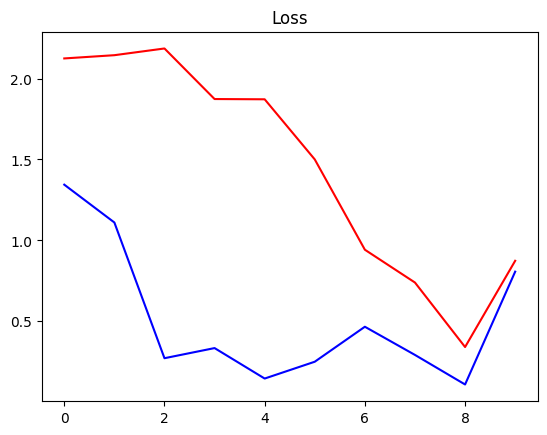

In [26]:
plt.title('Loss')
plt.plot(hist.history['loss'], 'r')
plt.plot(hist.history['val_loss'], 'b')
plt.show()

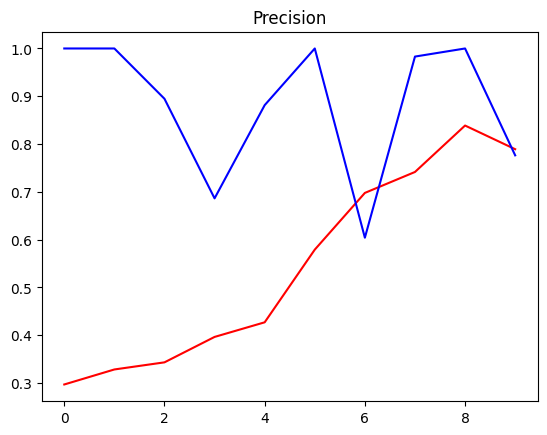

In [28]:
plt.title('Precision')
plt.plot(hist.history['precision'], 'r')
plt.plot(hist.history['val_precision'], 'b')
plt.show()

In [29]:
hist.history

{'loss': [2.124363899230957,
  2.1444003582000732,
  2.1859147548675537,
  1.8734381198883057,
  1.8718785047531128,
  1.5002260208129883,
  0.9422348737716675,
  0.7393775582313538,
  0.3409452438354492,
  0.8738231658935547],
 'precision': [0.2967033088207245,
  0.328125,
  0.34302327036857605,
  0.3962264060974121,
  0.4268292784690857,
  0.5789473652839661,
  0.6976743936538696,
  0.7414966225624084,
  0.8387096524238586,
  0.7891566157341003],
 'recall': [0.36000001430511475,
  0.40645161271095276,
  0.3907284736633301,
  0.44366195797920227,
  0.46979865431785583,
  0.6305732727050781,
  0.7692307829856873,
  0.7465753555297852,
  0.8496732115745544,
  0.8291139006614685],
 'val_loss': [1.3443466424942017,
  1.1105537414550781,
  0.2718181312084198,
  0.33442389965057373,
  0.14617601037025452,
  0.25013479590415955,
  0.46627873182296753,
  0.292065292596817,
  0.10949597507715225,
  0.8066813945770264],
 'val_precision': [1.0,
  1.0,
  0.8947368264198303,
  0.686274528503418,
 

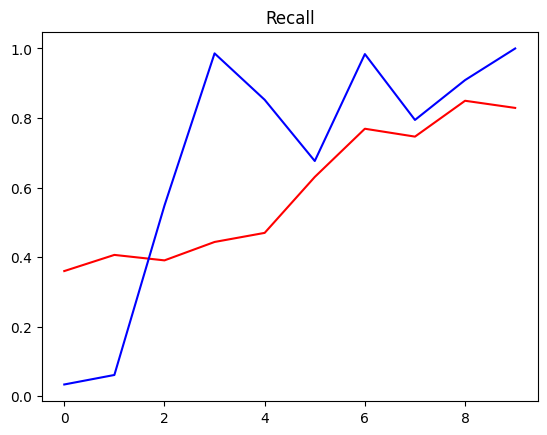

In [30]:
plt.title('Recall')
plt.plot(hist.history['recall'], 'r')
plt.plot(hist.history['val_recall'], 'b')
plt.show()

## 6. Hacer una predicción de una sola grabación

In [31]:
X_test, y_test = test.as_numpy_iterator().next()

In [32]:
y_test.shape

(16,)

In [33]:
yhat = model.predict(X_test)
yhat = [1 if prediction > 0.5 else 0 for prediction in yhat]
yhat

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


[1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0]

In [34]:
y_test.astype(int)

array([1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0])

## 7. Crear funciones de análisis forestal

In [35]:
import tensorflow as tf
import tensorflow_io as tfio

def load_mp3_16k_mono(filename):
    # Cargar como binario
    audio_binary = tf.io.read_file(filename)
    # Decodificar MP3
    audio, sample_rate = tfio.audio.decode_mp3(audio_binary)
    # Convertir a mono (promedio de canales)
    audio = tf.reduce_mean(audio, axis=1)
    # Resamplear a 16 kHz
    audio = tfio.audio.resample(audio, rate_in=sample_rate, rate_out=16000)
    return audio

In [36]:
mp3 = os.path.join(BASE_DIR, 'Forest Recordings', 'recording_00.mp3')